In [1]:
import logging
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
file_handler = logging.FileHandler('kernels.log', mode='w')
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - Time: %(message)s', datefmt='%H:%M:%S'))
console_handler = logging.StreamHandler()
console_handler.setLevel(logging.DEBUG)
console_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s', datefmt='%H:%M:%S'))
logger.addHandler(file_handler)
logger.addHandler(console_handler)


In [12]:
logger.info("*************************************START*************************************")

11:43:19 - INFO - *************************************START*************************************


In [13]:
mnist = keras.datasets.mnist
(x_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

# Selecting 5 samples each from digit '0' and '1'
x = np.concatenate([x_train_full[y_train_full == 0][:5], x_train_full[y_train_full == 1][:5]])
y = np.concatenate([y_train_full[y_train_full == 0][:5], y_train_full[y_train_full == 1][:5]])
x_test=np.concatenate([X_test[y_test == 0][:5], X_test[y_test == 1][:5]])
y_test=np.concatenate([y_test[y_test == 0][:5], y_test[y_test == 1][:5]])
logger.info(x.shape)

# Reshape x to add a channel dimension (for Conv2D layers)
'''
 if x originally has a shape of (10, 784), and you want to reshape it into images of shape 28x28, 
 the -1 lets NumPy calculate that the number of images is 10. The resulting shape will be (10, 28, 28, 1).
'''
x = x.reshape(-1, 28, 28, 1)
x_test=x_test.reshape(-1, 28, 28, 1)

logger.info(x.shape)
logger.info(y.shape)

11:43:21 - INFO - (10, 28, 28)
11:43:21 - INFO - (10, 28, 28, 1)
11:43:21 - INFO - (10,)


In [14]:
# Build the CNN model
model = models.Sequential([
    
    layers.Conv2D(2, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    
    layers.Dense(169, activation='relu'),

    layers.Dense(13, activation='relu'),
    
    layers.Dense(1, activation='sigmoid')
])

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 2)      │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 338)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 169)            │        57,291 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 13)             │         2,210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,535 (232.56 KB)

 Trainable params: 59,535 (232.56 KB)

 Non-trainable params: 0 (0.00 B)

11:43:30 - INFO - conv2d_1 filters shape: (3, 3, 1, 2)
11:43:30 - INFO - conv2d_1 biases_Conv shape: (2,)
11:43:30 - INFO - max_pooling2d_1 has no weights to display
11:43:30 - INFO - flatten_1 has no weights to display
11:43:30 - INFO - dense_3 weights shape: (338, 169)
11:43:30 - INFO - dense_3 biases_dense shape: (169,)
11:43:30 - INFO - dense_4 weights shape: (169, 13)
11:43:30 - INFO - dense_4 biases_dense shape: (13,)
11:43:30 - INFO - dense_5 weights shape: (13, 1)
11:43:30 - INFO - dense_5 biases_dense shape: (1,)


[[[[ 0.2663335  -0.15546286]]

  [[ 0.42922327 -0.33048534]]

  [[ 0.20684865 -0.46864206]]]


 [[[-0.41985533  0.22317532]]

  [[-0.27390718 -0.04461744]]

  [[ 0.05069545  0.39788446]]]


 [[[-0.01027349  0.23104283]]

  [[-0.03039315 -0.260772  ]]

  [[-0.21146804  0.2964596 ]]]]
[0. 0.]


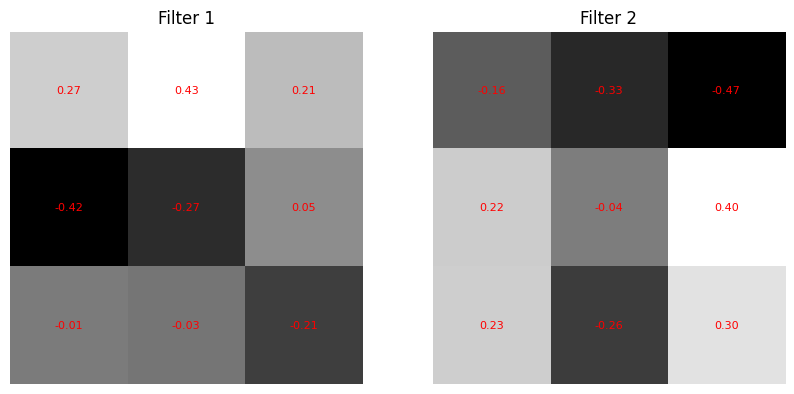

11:43:30 - INFO - Conv Layer 1 Weights:
11:43:30 - INFO - Mean: 0.0008004076080396771
11:43:30 - INFO - Variance: 0.06639648973941803
11:43:30 - INFO - Conv Layer 1 Biases:
11:43:30 - INFO - Mean: 0.0
11:43:30 - INFO - Variance: 0.0
11:43:30 - INFO - ------------------------------
11:43:30 - INFO - Conv Layer 2 Weights:
11:43:30 - INFO - Mean: -0.012379718944430351
11:43:30 - INFO - Variance: 0.08566848188638687
11:43:30 - INFO - Conv Layer 2 Biases:
11:43:30 - INFO - Mean: 0.0
11:43:30 - INFO - Variance: 0.0
11:43:30 - INFO - ------------------------------


In [16]:
weights=[]
baises_dense=[]

for layer in model.layers:
    if 'conv' in layer.name:
        filters, biases_Conv = layer.get_weights()
        logger.info(f"{layer.name} filters shape: {filters.shape}")
        logger.info(f"{layer.name} biases_Conv shape: {biases_Conv.shape}")
    elif 'dense' in layer.name:
        x, y = layer.get_weights()
        weights.append(x)
        baises_dense.append(y)
        logger.info(f"{layer.name} weights shape: {x.shape}")
        logger.info(f"{layer.name} biases_dense shape: {y.shape}")
    else:
        logger.info(f"{layer.name} has no weights to display")

print(filters)
print(biases_Conv)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.imshow(filters[:, :, 0, 0], cmap='gray')
ax.set_title('Filter 1')
ax.axis('off')
for (i, j), val in np.ndenumerate(filters[:, :, 0, 0]):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='red', fontsize=8)


ax = axes[1]
ax.imshow(filters[:, :, 0, 1], cmap='gray')
ax.set_title('Filter 2')
ax.axis('off')
for (i, j), val in np.ndenumerate(filters[:, :, 0, 1]):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='red', fontsize=8)

plt.show()

for i in range(2):
    mean = np.mean(filters[:, :, 0, i])
    variance = np.var(filters[:, :, 0, i])
    logger.info(f"Conv Layer {i + 1} Weights:")
    logger.info(f"Mean: {mean}")
    logger.info(f"Variance: {variance}")
    
    mean = np.mean(biases_Conv[i])
    variance = np.var(biases_Conv[i])
    logger.info(f"Conv Layer {i + 1} Biases:")
    logger.info(f"Mean: {mean}")
    logger.info(f"Variance: {variance}")
    logger.info("-" * 30)

In [17]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(x_train_full, y_train_full, epochs=5)


Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.1112 - loss: -2753558272.0000
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.1149 - loss: -150361407488.0000
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.1131 - loss: -964963270656.0000
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1149 - loss: -3011436347392.0000
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.1126 - loss: -6915191996416.0000


11:45:03 - INFO - conv2d_1 filters shape: (3, 3, 1, 2)
11:45:03 - INFO - conv2d_1 biases_Conv shape: (2,)
11:45:03 - INFO - max_pooling2d_1 has no weights to display
11:45:03 - INFO - flatten_1 has no weights to display
11:45:03 - INFO - dense_3 weights shape: (338, 169)
11:45:03 - INFO - dense_3 biases_dense shape: (169,)
11:45:03 - INFO - dense_4 weights shape: (169, 13)
11:45:03 - INFO - dense_4 biases_dense shape: (13,)
11:45:03 - INFO - dense_5 weights shape: (13, 1)
11:45:03 - INFO - dense_5 biases_dense shape: (1,)


[[[[14.803805 14.407116]]

  [[14.972055 14.248151]]

  [[14.749053 14.106298]]]


 [[[14.143234 14.778554]]

  [[14.289992 14.522056]]

  [[14.60641  14.951565]]]


 [[[14.553423 14.776416]]

  [[14.535198 14.294573]]

  [[14.348794 14.83479 ]]]]
[14.577728 14.583212]


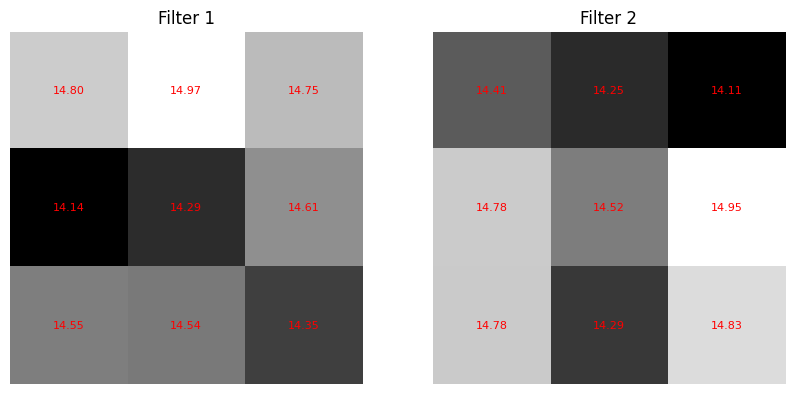

11:45:04 - INFO - Conv Layer 1 Weights:
11:45:04 - INFO - Mean: 14.555774688720703
11:45:04 - INFO - Variance: 0.062092125415802
11:45:04 - INFO - Conv Layer 1 Biases:
11:45:04 - INFO - Mean: 14.577728271484375
11:45:04 - INFO - Variance: 0.0
11:45:04 - INFO - ------------------------------
11:45:04 - INFO - Conv Layer 2 Weights:
11:45:04 - INFO - Mean: 14.546613693237305
11:45:04 - INFO - Variance: 0.08002015203237534
11:45:04 - INFO - Conv Layer 2 Biases:
11:45:04 - INFO - Mean: 14.583211898803711
11:45:04 - INFO - Variance: 0.0
11:45:04 - INFO - ------------------------------


In [18]:
weights=[]
baises_dense=[]

for layer in model.layers:
    if 'conv' in layer.name:
        filters, biases_Conv = layer.get_weights()
        logger.info(f"{layer.name} filters shape: {filters.shape}")
        logger.info(f"{layer.name} biases_Conv shape: {biases_Conv.shape}")
    elif 'dense' in layer.name:
        x, y = layer.get_weights()
        weights.append(x)
        baises_dense.append(y)
        logger.info(f"{layer.name} weights shape: {x.shape}")
        logger.info(f"{layer.name} biases_dense shape: {y.shape}")
    else:
        logger.info(f"{layer.name} has no weights to display")

print(filters)
print(biases_Conv)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.imshow(filters[:, :, 0, 0], cmap='gray')
ax.set_title('Filter 1')
ax.axis('off')
for (i, j), val in np.ndenumerate(filters[:, :, 0, 0]):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='red', fontsize=8)


ax = axes[1]
ax.imshow(filters[:, :, 0, 1], cmap='gray')
ax.set_title('Filter 2')
ax.axis('off')
for (i, j), val in np.ndenumerate(filters[:, :, 0, 1]):
    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='red', fontsize=8)

plt.show()

for i in range(2):
    mean = np.mean(filters[:, :, 0, i])
    variance = np.var(filters[:, :, 0, i])
    logger.info(f"Conv Layer {i + 1} Weights:")
    logger.info(f"Mean: {mean}")
    logger.info(f"Variance: {variance}")
    
    mean = np.mean(biases_Conv[i])
    variance = np.var(biases_Conv[i])
    logger.info(f"Conv Layer {i + 1} Biases:")
    logger.info(f"Mean: {mean}")
    logger.info(f"Variance: {variance}")
    logger.info("-" * 30)